In [91]:
import glob
import os 
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio
from scipy.stats import norm 
from scipy.stats import multivariate_normal
import time
import sys

flt_min = sys.float_info.min

%matplotlib notebook
%matplotlib inline

# Part Ⅱ A
In this part I import and display the original RGB images and masks(considered as ground truth) from apples.zip.
I use them to generate the training data RGBApple and RGBNonApple, which are two-dimensional arrays of size 3 * num. "num" represents the total number of apple/non-apple pixels in the three original images.

**Load and display RGB images and original masks in apple.zip**

In [92]:
#Load RGB images of apples
files = glob.glob("apples/*.jpg")
ColorImgs = []
for myFile in files:
    im = plt.imread(myFile)
    ColorImgs.append(im)

#Load Original Masks of apples,considered as groundtruth
files = glob.glob("apples/*.png")
GroundTruth = []
for myfile in files:
    gt_png = plt.imread(myfile)
    gt = cv2.cvtColor(gt_png, cv2.COLOR_RGB2GRAY)
    gt = gt.astype(np.float32)
    GroundTruth.append(gt)

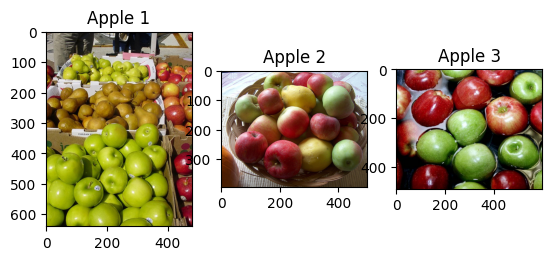

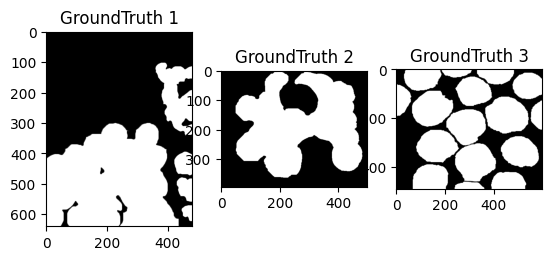

In [93]:
#Display the apples images and their original masks
for i in range(len(ColorImgs)):
    plt.subplot(1, len(ColorImgs), i + 1)  
    plt.imshow(ColorImgs[i])
    plt.title(f"Apple {i+1}")
plt.show()

for j in range(len(GroundTruth)):
    plt.subplot(1, len(GroundTruth), j+1)
    plt.imshow(GroundTruth[j], cmap='gray')
    plt.title(f"GroundTruth {j+1}")
plt.show()



**Generate Training Set**

In [94]:
RGBApple = []
RGBNonApple = []
for rgb_img, gt in zip(ColorImgs, GroundTruth):
    #extract apple pixels where gt >= 0.5
    idApple = np.where(gt >= 0.5)
    apple_pix = rgb_img[idApple]
    #extract non-apple pixels where gt < 0.5
    idNonApple = np.where(gt < 0.5)
    nonapple_pix = rgb_img[idNonApple]
    RGBApple.extend(apple_pix)
    RGBNonApple.extend(nonapple_pix)

#trans training data into numpy array
RGBApple = np.array(RGBApple).T / 255.0
print(RGBApple.shape)
RGBNonApple = np.array(RGBNonApple).T / 255.0
print(RGBNonApple.shape)


(3, 425694)
(3, 374606)


# Part Ⅱ B
Use mixtures of Gaussians to distinguish apple vs. non-apple pixels.

Directly use functions *getMixGaussLogLike* and *fitMixGauss* from practicalMixGaussC.

In [95]:
def getMixGaussLogLike(data, mixGaussEst): 
    """
    Calculate the log likelihood for the whole dataset under a mixture of Gaussians model.
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    mixGaussEst -- dict containing the mixture of gaussians parameters.

    Returns: 
    logLike -- scalar containing the log likelihood.
    
    """
    
    data = np.atleast_2d(data)                                                                         
    # find total number of data items                                                                  
    nDims, nData = data.shape                                                                          
    
    # initialize log likelihoods                                                                       
    logLike = 0;                                                                                       

    curWeight = mixGaussEst['weight'] #shape: (k,)
    curMean = mixGaussEst['mean'] #(d,k)
    curCov = mixGaussEst['cov'] #(d,k,k)
    
    like = 0                                                                                                   
    
    # run through each data item                                                                       
    for cData in range(nData):                                                                         
        thisData = data[:, cData]   #the shape of thisData:(nDims,)                                                             
        # TO DO - calculate likelihood of this data point under mixture of                         
        # Gaussians model. Replace this                                                                
        for cGauss in range (mixGaussEst['k']):
            guassProb = multivariate_normal.pdf(thisData, mean=curMean[:, cGauss], cov=curCov[:, :, cGauss])
            like += curWeight[cGauss] * guassProb


        #broadcast data for vectorized computation
        #broadcastedData = np.broadcast_to(thisData, curMean.shape)
        #gaussprobs = multivariate_normal.pdf(thisData.flatten(), mean=curMean.flatten(), cov=curCov.flatten())
        #like = np.sum(curWeight * gaussprobs)

        
        # add to total log like                                                                        
        logLike = np.sum(logLike + np.log(like))                                                               
                                                                                                       
    return  logLike.item()

In [96]:
def fitMixGauss(data, k):
    """
    Estimate a k MoG model that would fit the data. Incremently plots the outcome.
               
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    k -- scalar representing the number of gaussians to use in the MoG model.
    
    Returns: 
    mixGaussEst -- dict containing the estimated MoG parameters.
    
    """
    
    #     MAIN E-M ROUTINE  
    #     In the E-M algorithm, we calculate a complete posterior distribution over                                  
    #     the (nData) hidden variables in the E-Step.  
    #     In the M-Step, we update the parameters of the Gaussians (mean, cov, w).   
    
    nDims, nData = data.shape


    postHidden = np.zeros(shape=(k, nData))

    # we will initialize the values to random values
    mixGaussEst = dict()
    mixGaussEst['d'] = nDims
    mixGaussEst['k'] = k
    mixGaussEst['weight'] = (1 / k) * np.ones(shape=(k))
    mixGaussEst['mean'] = 2 * np.random.randn(nDims, k)
    mixGaussEst['cov'] = np.zeros(shape=(nDims, nDims, k))
    for cGauss in range(k):
        mixGaussEst['cov'][:, :, cGauss] = 2.5 + 1.5 * np.random.uniform() * np.eye(nDims)
        

    # calculate current likelihood
    # TO DO - fill in this routine
    logLike = getMixGaussLogLike(data, mixGaussEst)
    #print('Log Likelihood Iter 0 : {:4.3f}\n'.format(logLike))

    nIter = 30;

    logLikeVec = np.zeros(shape=(2 * nIter))
    boundVec = np.zeros(shape=(2 * nIter))

    #fig, ax = plt.subplots(1, 1)

    for cIter in range(nIter):

        # ===================== =====================
        # Expectation step
        # ===================== =====================
        
        curCov = mixGaussEst['cov']                                                                                  
        curWeight = mixGaussEst['weight']                                                                            
        curMean = mixGaussEst['mean']
        
        for cData in range(nData):
            thisData = data[:, cData]
            #curLik = 0
            # TO DO (g) : fill in column of 'hidden' - calculate posterior probability that
            # this data point came from each of the Gaussians
            # replace this:
            # broadcastedData = np.broadcast_to(thisData, curMean.shape)
            # curLik = curWeight * multivariate_normal.pdf(broadcastedData, mean=curMean, cov=curCov)
            # postHidden[:, cData] = curLik/np.sum(curLik)
            for cGauss in range (k):
                postHidden[cGauss, cData] = curWeight[cGauss] * multivariate_normal.pdf(thisData, mean=curMean[:, cGauss], cov=curCov[:, :, cGauss])
            
            postHidden[:, cData] /= np.sum(postHidden[:, cData])


        # ===================== =====================
        # Maximization Step
        # ===================== =====================
        # for each constituent Gaussian
        for cGauss in range(k):
            # TO DO (h):  Update weighting parameters mixGauss.weight based on the total
            # posterior probability associated with each Gaussian. Replace this:
            mixGaussEst['weight'][cGauss] = np.sum(postHidden[cGauss,:]) / np.sum(postHidden)
            
            
            # TO DO (i):  Update mean parameters mixGauss.mean by weighted average
            # where weights are given by posterior probability associated with
            # Gaussian.  Replace this:
            mixGaussEst['mean'][:,cGauss] = np.sum((postHidden[cGauss, :] * data), axis=1) / np.sum(postHidden[cGauss, :])
            
            
            # TO DO (j):  Update covarance parameter based on weighted average of
            # square distance from update mean, where weights are given by
            # posterior probability associated with Gaussian
            # centered_data = data - mixGaussEst['mean'][:,cGauss].reshape(2,1) #shape:(d,n)
                        
            centered_data = data - np.expand_dims(mixGaussEst['mean'][:, cGauss], axis=1)
            mixGaussEst['cov'][:, :, cGauss] = np.dot(postHidden[cGauss, :] * centered_data, centered_data.T) / np.sum(postHidden[cGauss, :])
                      
            
            # draw the new solution
        # drawEMData2d(data, mixGaussEst)
        # time.sleep(0.7)
        # fig.canvas.draw()

        # calculate the log likelihood
        logLike = getMixGaussLogLike(data, mixGaussEst)
        #print('Log Likelihood After Iter {} : {:4.3f}\n'.format(cIter, logLike))


    return mixGaussEst

**Define a function to the probability density of a n-dimensional array using a mixture of Gaussian distributions,** which will be used to calculate *likeApple* and *likeNonApple*

In [97]:
def calcMoGProb(data, mixGauss):
    """
    Compute the probability density of a n-dimensional array using a mixture of Gaussian distributions.

    Keyword arguments:
    data -- d by n matrix containing data points.
    mixGauss -- dict with mixture of gaussian information.

    
    """
    nDim, nData = data.shape
    k = mixGauss['k']
    
    MoGProb = np.zeros((nData))

    for cGauss in range(k):
        weight = mixGauss['weight'][cGauss]
        mean = mixGauss['mean'][:, cGauss]
        cov = mixGauss['cov'][:, :, cGauss]

        kth_MoGProb = weight * multivariate_normal.pdf(data.T, mean=mean, cov=cov)

    MoGProb += kth_MoGProb

    return MoGProb

   


**Define a function to calculate the posterior probability that a pixel belongs to apple or non-apple.**

In [98]:
def calcPosteriorApple(img, mixGaussApple, mixGaussNonApple):
    #Define priors for whether the pixel is apple or Non-apple
    priorApple = 0.5;
    priorNonApple = 1. - priorApple

    imY, imX, imZ = img.shape
    posteriorApple = np.zeros([imY,imX])    

    #Transform the image data into an array with a shape of (3, num_pixels), 
    # where num_pixels is the total number of pixels in the image.
    data = img.transpose(2, 0, 1).reshape(3, -1)
    data = data / 255.0
    
    #Calculate likelihood of data given apple/non-apple model
    likeApple = calcMoGProb(data, mixGaussApple)
    likeNonApple = calcMoGProb(data, mixGaussNonApple)
    
    #Calculate posterior probability of that pixels belong to apple/non-apple region
    posteriorApple = likeApple * priorApple / (likeApple * priorApple + likeNonApple * priorNonApple)
    posteriorApple = posteriorApple.reshape(imY, imX)

    return posteriorApple


**Fit MoG models for apple/non-apple data**

From the training images, it appears that apples are either red or green. 

The RGB pixel values of red apples follow a three-dimensional Gaussian distribution, 
and those of green apples follow another three-dimensional Gaussian distribution. 

Therefore, selecting k_apple = 2

In [99]:

k_apple = 2
#Can not infer the best number of k for non-apple data, I choose 3 here
k_nonapple = 3;
#Fit MoG model for apple data. We choose all apple pixels from training set
mixGaussApple = fitMixGauss(RGBApple[:, :], k_apple);

#Fit MoG model for Non-apple data
mixGaussNonApple = fitMixGauss(RGBNonApple[:, :], k_nonapple);


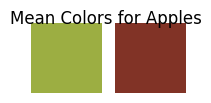

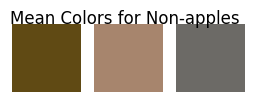

In [123]:
#display the mean(color) of generated MoG model for apples and non-apples
#mean colors for apples
apple_color1 = np.ones((1, 1, 3)) * mixGaussApple['mean'][:, 0]
apple_color2 = np.ones((1, 1, 3)) * mixGaussApple['mean'][:, 1]

plt.figure(figsize=(2, 1))
plt.suptitle("Mean Colors for Apples")

plt.subplot(1, 2, 1)
plt.imshow(apple_color1)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(apple_color2)
plt.axis('off')

#mean colors for non-apples, I choose k=3 for non-apple data, so I have 3 colors for non-apples
nonApple_color1 = np.ones((1, 1, 3)) * mixGaussNonApple['mean'][:, 0]
nonApple_color2 = np.ones((1, 1, 3)) * mixGaussNonApple['mean'][:, 1]
nonApple_color3 = np.ones((1, 1, 3)) * mixGaussNonApple['mean'][:, 2]

plt.figure(figsize=(3, 1))
plt.suptitle("Mean Colors for Non-apples")

plt.subplot(1, 3, 1)
plt.imshow(nonApple_color1)
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(nonApple_color2)
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(nonApple_color3)
plt.axis('off')

plt.show()

So far, the results look promising. It's evident that apples have average colors, with one being red and the other green, which aligns with my expectations. The background colors also seem correct.

**Display the results of the model on the three original RGB images.**

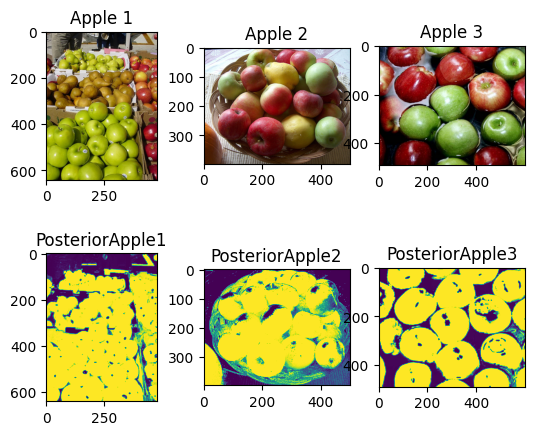

In [124]:
for i in range(len(ColorImgs)):
    plt.subplots_adjust(hspace=0.5)
    plt.subplot(2, len(ColorImgs), i + 1)  
    plt.imshow(ColorImgs[i])
    plt.title(f"Apple {i+1}")

    plt.subplot(2, len(ColorImgs), i + len(ColorImgs) + 1)
    posteriorImg = calcPosteriorApple(ColorImgs[i], mixGaussApple, mixGaussNonApple)
    plt.imshow(posteriorImg)
    plt.title(f"PosteriorApple{i+1}")
plt.show()


It seems like the model's performance on the training data is not optimal. The background is well-distinguished in all three images, but nearly all other fruits are classified as apples. I believe this might be due to the similarity in color, as the training data only includes RGB color information. The model struggles to differentiate fruits based on shape or other characteristics.

# Part Ⅱ C
Distinguish apple vs. non-apple pixels in images from testApples.zip. Show each
pixel’s posterior probability of being “apple.”

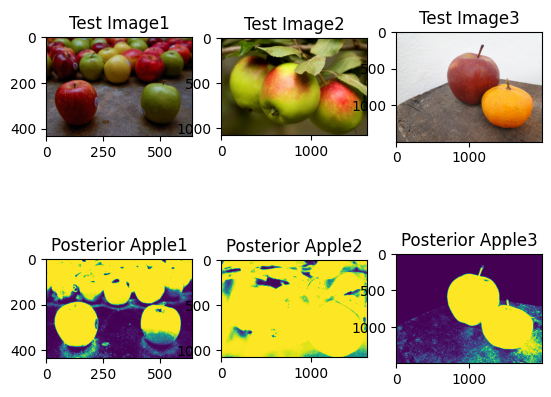

In [127]:
#Load test RGB images from 'testApples'
files = glob.glob("testApples/*.jpg")
TestImgs = []
for myFile in files:
    test = plt.imread(myFile)
    TestImgs.append(test)

#Dispaly original test images and posterior probability of being 'apple' in test images
PosteriorTests = []
for i in range(len(TestImgs)):
    plt.subplots_adjust(hspace=0.5)
    plt.subplot(2, len(TestImgs), i+1)
    plt.imshow(TestImgs[i])
    plt.title(f"Test Image{i+1}")

    plt.subplot(2, len(TestImgs), i + len(TestImgs) + 1)
    posteriorTest = calcPosteriorApple(TestImgs[i], mixGaussApple, mixGaussNonApple)
    #store results
    PosteriorTests.append(posteriorTest)
    plt.imshow(posteriorTest)
    plt.title(f"Posterior Apple{i+1}")
plt.show()

## Analyze the results:
**Performance:**

In the first image, the results appear quite promising. It is intriguing that the yellow apples, which were not present in the training data, are also well-classified here. This may be attributed to the two fitted Gaussian distributions having a significant overlap in the yellow region. 

However, in the second image, the results are unsatisfactory. This is likely due to the abundance of green in both the apple leaves and the background, with only the dark shadows successfully distinguished. 

In the third image, the background is well-separated, but the orange is almost entirely misclassified as apples. 

Additionally, the highlights on the apples in the image are scarcely categorized as apples.

**The possible reasons for the unsatisfactory results:**

The reasons can be attributed to both inherent limitations of the simple Gaussian Mixture Model itself and inadequacies in my practical implementation process.

The MoG model indeed focuses solely on the RGB color channels of pixels, overlooking essential information beyond color, such as shape, crucial for distinguishing apples. Additionally, the model neglects the spatial continuity of pixels and the potential color variations within a single apple, leading to the misclassification of highlights on apples as non-apple regions.

During the Gaussian model fitting process, the epoch (nIter) value is set to 30. Increasing this value might enhance the model's performance. Additionally, despite having the same k value and epoch count in the training data, variations in performance between my model and my classmates' model could be attributed to the randomness in the initialization of variables during the model fitting process. However, I cannot definitively confirm this.





# Part Ⅱ D
For the test image with a ground-truth mask, I segment apples with a range of threshold values and dispaly my attempts.

To find out the best threshold, I quantify my results with a ROC curve.

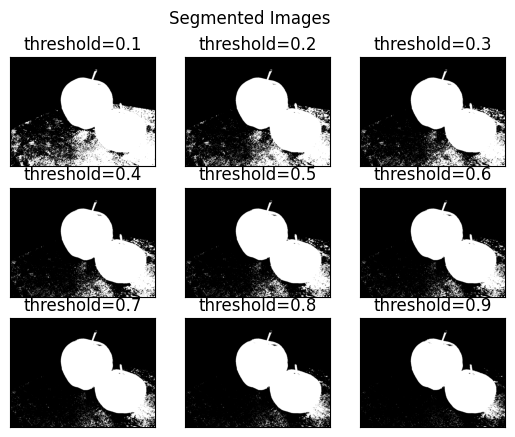

In [104]:
#for the test image with a groundtruth mask, try a range of thresholds and segment the image
thresholds = np.linspace(0.1, 0.9, 9)

fig, axs = plt.subplots(3, 3)
fig.suptitle(f"Segmented Images")
for i, ax in enumerate(axs.flatten()):
    threshold = round(thresholds[i], 1)
    seg_img = np.where(PosteriorTests[2] > threshold, 1, 0)
    
    #display the results
    ax.imshow(seg_img, cmap='gray')
    ax.set_title(f"threshold={threshold}")
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()



Threshold=0.9 still seems small.

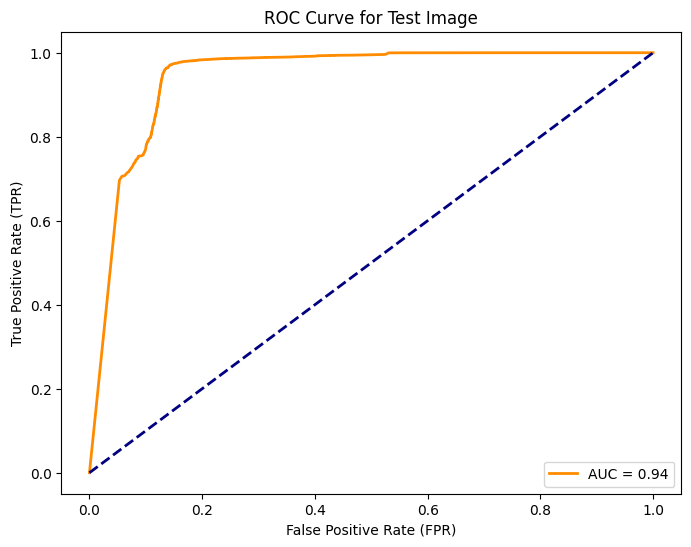

In [135]:
#quantify the results using ROC curve
from sklearn.metrics import roc_curve, auc

#Laod groundtruth mask for the test image
path = "testApples/gt_test.png"
gt_test = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
gt_test = np.where(gt_test > 0.5, 1, 0)

#calculate the ROC curve
fpr, tpr, thresholds = roc_curve(gt_test.flatten(), PosteriorTests[2].flatten())
#Calculate the Area Under the Curve (AUC)
#AUC represents the area under the ROC curve, with values ranging from 0 to 1. A higher AUC, closer to 1, indicates better model performance.
roc_auc = auc(fpr, tpr)

#dispaly ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Test Image')
plt.legend()
plt.show()



In [136]:
#Use ROC curve to find the best threshold to segment the image
#Calculate the Euclidean distance from each point on the ROC curve to the point (0, 1)
distance = np.sqrt((fpr - 0)**2 + (tpr - 1)**2)

#Find the index of the minimum distance
idx = np.argmin(distance)

# Get the best threshold
best_threshold = thresholds[idx]

print(f"Best Threshold: {best_threshold}")

Best Threshold: 0.9937912853704328


The computed optimal threshold also aligns with the visual results from my initial threshold attempts.

<function matplotlib.pyplot.show(close=None, block=None)>

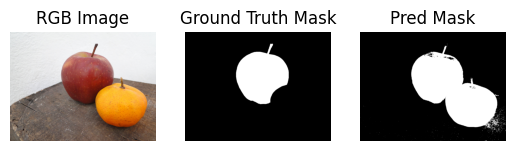

In [138]:
#Use the best threshold to segment the test image with groundtruth
seg_img_test = np.where(PosteriorTests[2] > best_threshold, 1, 0)

#Dispaly the results
plt.subplot(1, 3, 1)
plt.imshow(TestImgs[2], cmap='gray')
plt.title("RGB Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(gt_test, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(seg_img_test, cmap='gray')
plt.title("Pred Mask")
plt.axis('off')

plt.show

# Part Ⅱ E
Use two non-copyrighted photos from https://search.creativecommons.org/ as my test images.

Use Glimp to generate ground truth masks of apples in the images.(inexact, painted by hand)

Dispaly my qualitative and
quantitative results.

In [141]:
#Load my test images and ground truth masks， and compute posterior that pixels belong to apples in the images
PosteriorMyApple = []

files = glob.glob("myApples/*.jpg")
myAppleImgs = []
for myFile in files:
    myApple = plt.imread(myFile)
    posteriorMyApple = calcPosteriorApple(myApple, mixGaussApple, mixGaussNonApple)
    myAppleImgs.append(myApple)
    PosteriorMyApple.append(posteriorMyApple)

files = glob.glob("myApples/*.png")
GT_myAplle = []
for myfile in files:
    gt_myApple = plt.imread(myfile)
    gt_myApple = cv2.cvtColor(gt_myApple, cv2.COLOR_RGB2GRAY).astype(np.float32)
    gt_myApple = np.where(gt_myApple > 0.5, 1, 0)    
    GT_myAplle.append(gt_myApple)


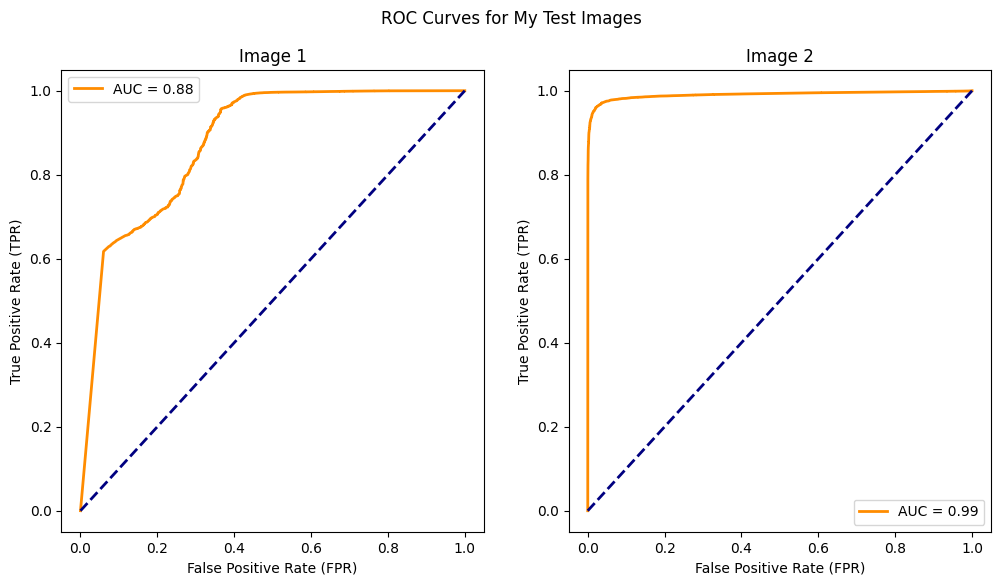

In [152]:
#quantify the results using ROC curve
#calculate the ROC curve
fpr_1, tpr_1, thresholds_1 = roc_curve(GT_myAplle[0].flatten(), PosteriorMyApple[0].flatten())
fpr_2, tpr_2, thresholds_2 = roc_curve(GT_myAplle[1].flatten(), PosteriorMyApple[1].flatten())

#Calculate the Area Under the Curve (AUC)
roc_auc1 = auc(fpr_1, tpr_1)
roc_auc2 = auc(fpr_2, tpr_2)

#dispaly ROC curves
fig_ROC, axs_ROC = plt.subplots(1, 2, figsize=(12, 6))
fig_ROC.suptitle("ROC Curves for My Test Images")

axs_ROC[0].plot(fpr_1, tpr_1, color='darkorange', lw=2, label=f'AUC = {roc_auc1:.2f}')
axs_ROC[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs_ROC[0].set_xlabel('False Positive Rate (FPR)')
axs_ROC[0].set_ylabel('True Positive Rate (TPR)')
axs_ROC[0].set_title("Image 1")

axs_ROC[1].plot(fpr_2, tpr_2, color='darkorange', lw=2, label=f'AUC = {roc_auc2:.2f}')
axs_ROC[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs_ROC[1].set_xlabel('False Positive Rate (FPR)')
axs_ROC[1].set_ylabel('True Positive Rate (TPR)')
axs_ROC[1].set_title("Image 2")

axs_ROC[0].legend()
axs_ROC[1].legend()
plt.show()

In [153]:
#Use ROC curve to find the best threshold to segment the image
#Calculate the Euclidean distance from each point on the ROC curve to the point (0, 1)
distance1 = np.sqrt((fpr_1 - 0)**2 + (tpr_1 - 1)**2)
distance2 = np.sqrt((fpr_2 - 0)**2 + (tpr_2 - 1)**2)

#Find the index of the minimum distance
idx1 = np.argmin(distance1)
idx2 = np.argmin(distance2)

# Get the best threshold
best_threshold1 = thresholds_1[idx1]
best_threshold2 = thresholds_2[idx2]

print(f"Best Threshold for My Image 1: {best_threshold1}")
print(f"Best Threshold for My Image 2: {best_threshold2}")

Best Threshold for My Image 1: 0.9999984535339898
Best Threshold for My Image 2: 0.867449187061945


<function matplotlib.pyplot.show(close=None, block=None)>

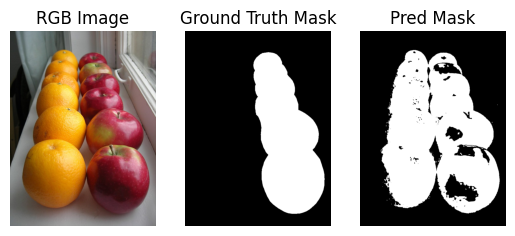

In [154]:
#Use the best threshold to segment the test image with groundtruth
seg_img_test1 = np.where(PosteriorMyApple[0] > best_threshold1, 1, 0)

#Dispaly the results
plt.subplot(1, 3, 1)
plt.imshow(myAppleImgs[0], cmap='gray')
plt.title("RGB Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(GT_myAplle[0], cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(seg_img_test1, cmap='gray')
plt.title("Pred Mask")
plt.axis('off')

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

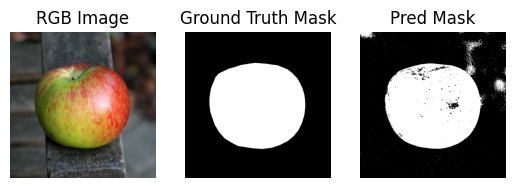

In [155]:
#Use the best threshold to segment the test image with groundtruth
seg_img_test2 = np.where(PosteriorMyApple[1] > best_threshold2, 1, 0)

#Dispaly the results
plt.subplot(1, 3, 1)
plt.imshow(myAppleImgs[1], cmap='gray')
plt.title("RGB Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(GT_myAplle[1], cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(seg_img_test2, cmap='gray')
plt.title("Pred Mask")
plt.axis('off')

plt.show

## Analyze the results:
From the AUC values of the two images (auc1 = 0.88, auc2 = 0.99), it is evident that the model performs better on the second image compared to the first. Similar to the previous issue, in the first image where there are many oranges misclassified as apples, I believe it's due to significant overlap of the two Gaussian distributions in the yellow region within the MoG model. In the second image, with only a single isolated apple, the segmentation is better, but some red and green areas in the background are misclassified as apples. Moreover, highlights on the apples are still categorized as non-apple regions.

**In summary,** the model exhibits significant misclassification of orange objects. Moreover, due to its exclusive consideration of pixel RGB values, the segmentation capability is severely constrained.


# Part Ⅱ F

**We should really be using three separate sets of files: a training set, a validation set, and a test set! Explain why.**

When employing a MoG model for image segmentation, the division into training, validation, and test sets is crucial.

Training Set: Analogous to a classroom setting, the MoG learns patterns and color distributions of different regions within the images through the training set. By adjusting its parameters, the model strives to comprehend the intricate relationships present in the image data.

Validation Set: This serves as a practice exam. Post each training iteration, the model assesses its performance on the validation set. This practice helps prevent the model from mere memorization of the training set (overfitting), ensuring it genuinely learns to generalize well to novel, unseen data.

Test Set: This corresponds to the final exam. Comprising entirely new data that the model has not encountered during training or validation, the test set evaluates the model's true learning capabilities and its capacity to handle unfamiliar situations. It serves as a robust indicator of the model's real-world performance.

By segregating the dataset into these three components, a comprehensive evaluation of the model's performance is facilitated. This approach ensures that the model not only performs well on known data but also exhibits effectiveness in image segmentation when confronted with previously unseen data in real-world scenarios.








